# Setup

In [5]:
!pip install -q open_clip_torch transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.8.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*

In [6]:
import numpy as np
import pandas as pd
import os
import open_clip
import cv2
import matplotlib.pyplot as plt
import torch

from numpy.linalg import norm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from torchvision import transforms
from sklearn.decomposition import PCA

In [17]:
TEST_FOLDER = '/kaggle/input/appman-image-search/test/images'
QUERY_FOLDER = '/kaggle/input/appman-image-search/queries/queries'

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class PadToSquare(object):
    def __init__(self):
        return

    def __call__(self, image):
        width, height = image.size
        l, t, r, b = 0, 0, 0, 0

        if width < height:
            lr = height - width
            if lr % 2 == 0:
                l, r = lr // 2, lr // 2
            else:
                l, r = lr // 2 + 1, lr // 2

        elif height < width:
            tb = width - height
            if tb % 2 == 0:
                t, b = tb // 2, tb // 2
            else:
                t, b = tb // 2 + 1, tb // 2
        
        padding = transforms.Pad([l, t, r, b], padding_mode='edge')
        return padding(image)

In [9]:
model, _, org_transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k",
  device=device
)

transform = transforms.Compose([
    PadToSquare(),
    org_transform
])

transform_gray = transforms.Compose([
    PadToSquare(),
    transforms.Grayscale(3),
    org_transform
])

Downloading:   0%|          | 0.00/2.55G [00:00<?, ?B/s]

In [6]:
transform

Compose(
    Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f48443aef80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
)

In [8]:
transform_gray

Compose(
    Grayscale(num_output_channels=3)
    Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f48443aef80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
)

# Get train image embeddings

In [13]:
data_df = pd.read_csv('/kaggle/input/appman-image-search/sample_submission.csv')

In [10]:
query_ls = []

for dirname, _, filenames in os.walk(QUERY_FOLDER):
    for filename in filenames:
        if filename.endswith('.jpg'):
            query_ls.append([
                filename,
                dirname.split('/')[-1]
            ])
query_df = pd.DataFrame(query_ls, columns=['filepath', 'class'])

In [15]:
data_df = data_df.rename(columns={'img_file': 'filepath'})
data_df = data_df.drop('class', axis=1)

In [12]:
query_df = query_df.drop('class', axis=1)

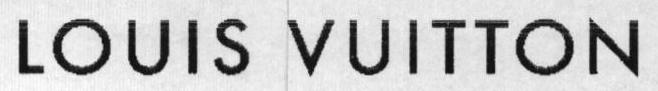

In [14]:
Image.open(os.path.join(QUERY_FOLDER, query_df.iloc[1]['filepath'])).convert("RGB")

In [15]:
class LogoDataset(Dataset):
    def __init__(self, df, transform, folder):
        self.df = df
        self.transform = transform
        self.folder = folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.transform(Image.open(os.path.join(self.folder, self.df.iloc[idx]['filepath'])).convert("RGB"))

In [16]:
data_ds = LogoDataset(data_df, transform, TEST_FOLDER)
data_gray_ds = LogoDataset(data_df, transform_gray, TEST_FOLDER)
query_ds = LogoDataset(query_df, transform, QUERY_FOLDER)

data_loader = DataLoader(data_ds, batch_size=64)
data_gray_loader = DataLoader(data_gray_ds, batch_size=64)
query_loader = DataLoader(query_ds, batch_size=64)

In [17]:
query_ds[1].shape

torch.Size([3, 224, 224])

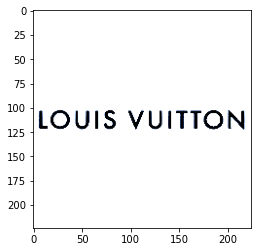

In [18]:
plt.imshow(query_ds[1].permute(1, 2, 0))

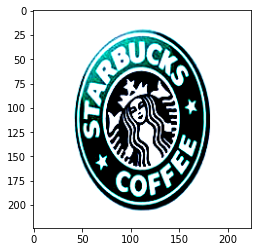

In [19]:
plt.imshow(data_ds[1006].permute(1, 2, 0))

In [20]:
embs = []
running_vloss = 0

with torch.no_grad():
    for inputs in tqdm(data_loader):
        inputs = inputs.to(device)
        outputs = model.encode_image(inputs)

        embs.append(outputs.detach().cpu().numpy())
        
data_embs = np.concatenate(embs)
data_embs.shape

100%|██████████| 18/18 [00:43<00:00,  2.44s/it]


(1120, 768)

In [21]:
embs = []
running_vloss = 0

with torch.no_grad():
    for inputs in tqdm(data_gray_loader):
        inputs = inputs.to(device)
        outputs = model.encode_image(inputs)

        embs.append(outputs.detach().cpu().numpy())
        
data_gray_embs = np.concatenate(embs)
data_gray_embs.shape

100%|██████████| 18/18 [00:33<00:00,  1.85s/it]


(1120, 768)

In [22]:
embs = []
running_vloss = 0

with torch.no_grad():
    for inputs in tqdm(query_loader):
        inputs = inputs.to(device)
        outputs = model.encode_image(inputs)

        embs.append(outputs.detach().cpu().numpy())
        
query_embs = np.concatenate(embs)
query_embs.shape

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


(22, 768)

In [23]:
data_df['emb'] = list(data_embs)
data_gray_df = data_df.copy()
data_gray_df['emb'] = list(data_gray_embs)
query_df['emb'] = list(query_embs)

In [26]:
data_df

,filepath,emb
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,"[0.029561417, -0.0043590222, -0.011119509, -0...."
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,"[0.016179526, 0.01213427, -0.023198653, -0.028..."
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,"[0.020371445, 0.008576356, -0.004250198, -0.03..."
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,"[-0.034779996, 0.004299413, -0.025104089, -0.0..."
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,"[-0.057136115, 0.039617643, 0.0071266373, -0.0..."
...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,"[-0.009982235, -0.023485921, 0.003252458, -0.0..."
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,"[-0.006095973, -0.015596108, 0.010984229, -0.0..."
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,"[-0.0031055103, -0.023985418, 0.0071847066, -0..."
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[-0.010973063, -0.024822615, 0.0046358434, -0...."


In [27]:
data_gray_df

,filepath,emb
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,"[0.029561417, -0.0043590222, -0.011119509, -0...."
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,"[0.006524515, 0.01146688, -0.025993623, -0.045..."
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,"[0.015663803, 0.0074477633, -0.0050703045, -0...."
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,"[-0.047577154, 0.012124544, -0.023625297, -0.0..."
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,"[-0.060668338, 0.042227168, 0.0042858375, -0.0..."
...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,"[-0.007571117, -0.022883724, -0.0027532743, -0..."
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,"[-0.01784463, -0.011075748, 0.015004325, -0.02..."
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,"[-0.017135482, -0.015464514, 0.009539247, -0.0..."
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[-0.013931202, -0.02493983, -0.00061548356, -0..."


In [43]:
torch.save(query_embs, 'query.pt')
torch.save(data_embs, 'test.pt')
torch.save(data_gray_embs, 'test_gray.pt')

# Evaluate

In [24]:
data_emb = np.stack(data_df['emb'])
data_gray_emb = np.stack(data_gray_df['emb'])
query_emb = np.stack(query_df['emb'])
print(data_emb.shape)
print(data_gray_emb.shape)
print(query_emb.shape)

(1120, 768)
(1120, 768)
(22, 768)


In [25]:
data_df = data_df[['filepath', 'emb']]
data_gray_df = data_gray_df[['filepath', 'emb']]

In [26]:
data_gray_df

,filepath,emb
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,"[0.029561417, -0.0043590222, -0.011119509, -0...."
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,"[0.006524515, 0.01146688, -0.025993623, -0.045..."
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,"[0.015663803, 0.0074477633, -0.0050703045, -0...."
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,"[-0.047577154, 0.012124544, -0.023625297, -0.0..."
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,"[-0.060668338, 0.042227168, 0.0042858375, -0.0..."
...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,"[-0.007571117, -0.022883724, -0.0027532743, -0..."
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,"[-0.01784463, -0.011075748, 0.015004325, -0.02..."
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,"[-0.017135482, -0.015464514, 0.009539247, -0.0..."
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[-0.013931202, -0.02493983, -0.00061548356, -0..."


In [27]:
result = euclidean_distances(query_emb, data_emb)
result_gray = euclidean_distances(query_emb, data_gray_emb)
print(result.shape)
print(result_gray.shape)

(22, 1120)
(22, 1120)


In [28]:
result_gray

array([[1.1702085 , 0.94860387, 0.98658407, ..., 1.1873566 , 1.1889547 ,
        1.1925328 ],
       [0.9796072 , 1.0377889 , 1.0609095 , ..., 1.0426927 , 1.0395297 ,
        1.0356623 ],
       [1.0585583 , 0.82702595, 0.84753335, ..., 1.0833788 , 1.0731287 ,
        1.0655828 ],
       ...,
       [1.0787652 , 1.1142274 , 1.1072867 , ..., 1.0688146 , 1.0342999 ,
        1.0402395 ],
       [1.1301391 , 0.7519006 , 0.7775747 , ..., 1.1836376 , 1.1527468 ,
        1.1465575 ],
       [1.0729723 , 1.0820479 , 1.1064606 , ..., 1.1587946 , 1.1653246 ,
        1.1652675 ]], dtype=float32)

In [37]:
data_df['pred'] = '22.jpg'
data_df['min'] = 1000

In [38]:
data_df

,filepath,emb,pred,min
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,"[0.029561417, -0.0043590222, -0.011119509, -0....",22.jpg,1000
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,"[0.016179526, 0.01213427, -0.023198653, -0.028...",22.jpg,1000
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,"[0.020371445, 0.008576356, -0.004250198, -0.03...",22.jpg,1000
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,"[-0.034779996, 0.004299413, -0.025104089, -0.0...",22.jpg,1000
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,"[-0.057136115, 0.039617643, 0.0071266373, -0.0...",22.jpg,1000
...,...,...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,"[-0.009982235, -0.023485921, 0.003252458, -0.0...",22.jpg,1000
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,"[-0.006095973, -0.015596108, 0.010984229, -0.0...",22.jpg,1000
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,"[-0.0031055103, -0.023985418, 0.0071847066, -0...",22.jpg,1000
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[-0.010973063, -0.024822615, 0.0046358434, -0....",22.jpg,1000


In [39]:
np.min(result)

0.051919546

In [40]:
thres = 0.6

for i in tqdm(range(len(result))):
    pred = query_df.iloc[i]['filepath']
    result_min = np.minimum(result, result_gray)
    new_min = np.where(result_min[i] < thres, result_min[i], 1000)
    m = data_df['min']
    data_df['pred'] = data_df['pred'].where(new_min >= m, pred)
    data_df['min'] = data_df['min'].where(new_min >= m, new_min)

100%|██████████| 22/22 [00:00<00:00, 487.75it/s]


In [42]:
data_df.value_counts('pred')

pred
22.jpg    487
20.jpg    198
3.jpg     112
9.jpg      74
10.jpg     68
5.jpg      48
1.jpg      42
14.jpg     20
6.jpg      17
11.jpg     15
18.jpg     10
13.jpg      7
0.jpg       5
4.jpg       4
21.jpg      3
15.jpg      3
7.jpg       2
2.jpg       2
19.jpg      1
12.jpg      1
8.jpg       1
dtype: int64

In [43]:
data_df

,filepath,emb,pred,min
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,"[0.029561417, -0.0043590222, -0.011119509, -0....",12.jpg,0.3506
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,"[0.016179526, 0.01213427, -0.023198653, -0.028...",22.jpg,1000.0000
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,"[0.020371445, 0.008576356, -0.004250198, -0.03...",22.jpg,1000.0000
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,"[-0.034779996, 0.004299413, -0.025104089, -0.0...",22.jpg,1000.0000
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,"[-0.057136115, 0.039617643, 0.0071266373, -0.0...",22.jpg,1000.0000
...,...,...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,"[-0.009982235, -0.023485921, 0.003252458, -0.0...",22.jpg,1000.0000
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,"[-0.006095973, -0.015596108, 0.010984229, -0.0...",22.jpg,1000.0000
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,"[-0.0031055103, -0.023985418, 0.0071847066, -0...",22.jpg,1000.0000
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[-0.010973063, -0.024822615, 0.0046358434, -0....",22.jpg,1000.0000


In [45]:
sub_df = data_df[['filepath', 'pred']].rename(columns={'filepath': 'img_file', 'pred': 'class'})
sub_df['class'] = sub_df['class'].apply(lambda x: int(x.replace('.jpg', '')))

In [46]:
sub_df

,img_file,class
0,64ccfecf-e451-49a8-aa3f-acf2622a9a5c.jpg,12
1,c6df1385-382a-4428-b41e-f2d729b90c87.jpg,22
2,af30e9d0-da6e-42bd-814e-c70a0c16e554.jpg,22
3,3fc8998e-0324-426c-8233-6b76abc7e200.jpg,22
4,309d1085-0d11-4411-9555-b24cc8fcee02.jpg,22
...,...,...
1115,43b3052a-11b6-410f-9dae-c8c60b347bb2.jpg,22
1116,ea11503b-de43-43e3-b46b-6a84e528217c.jpg,22
1117,9daf6dc7-ab1c-43fa-a733-ae9131d3686a.jpg,22
1118,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,22


In [48]:
sub_df.to_csv('sub_coca_eu_pad_edge.csv', index=False)